# Tracking messages

Goal: run in parallel Max-Sum with noise and the RS equations and compute at each iteration:
- The histogram of rounded messages
- The distribution $p(f)$
- The distortion computed on the non-rounded beliefs
- The distortion computed on rounded beliefs

In [52]:
include("../code/headers.jl")

Pick graph size and connectivity

In [87]:
n = factorial(7)
k = 3
R = 1 .- 2 ./k
m_ = n*(1 .- R)
m = Int.(round.(m_))
m_

3360.0

Initalize

In [86]:
randseed = 123
rng = MersenneTwister(randseed)
algo = MS(maxiter=300, Tmax=1, gamma=0.0, sigma=1e-10)
Y = [rand(rng, [0,1], n) for mm in m]
S = [1 .- 2*y for y in Y]
msgs = [[Vector{Vector{Float64}}(undef,m) for it in 1:algo.maxiter] for _ in m]
beliefs = [[zeros(n) for it in 1:algo.maxiter] for _ in m]
graphs = Vector{FactorGraph}(undef,length(m))
free_energies = [zeros(algo.maxiter) for _ in m]
N = 10 
p = [[OffsetArray(1/(2N+1)*ones(2N+1), -N:N) for it in 1:algo.maxiter+1] for _ in m];

Define function to update $p(f)$ and compute overlap on it 

In [84]:
function itergen(p,K)
    N = lastindex(p)
    p1 = copy(p)
    p1 .= 0
    S = CartesianIndices(Tuple(fill(0:1,K-1)))
    for F in CartesianIndices(Tuple(fill(-N:N,K-1)))
        ff = Tuple(F)
        P = prod(p[fi] for fi in ff)
        for fs in map(s -> ff .+ (2 .* Tuple(s) .- 1), S)
            f = minimum(abs.(fs))*sign(prod(fs))
            #println("$ff $fs $f $P")
            p1[clamp(f, -N, N)] += P
        end
    end
    p1 / sum(p1)
end

function overgen(p,K)
    N = lastindex(p)
    O = 0.0
    S = CartesianIndices(Tuple(fill(0:1,K)))
    for ff in map(Tuple, CartesianIndices(Tuple(fill(-N:N,K))))
        P = prod(p[fi] for fi in ff)
        for fs in map(s -> ff .+ (2 .* Tuple(s) .- 1), S)
            O += P*sum(abs.(fs).-abs.(ff))
            if prod(fs) < 0
                O -= P*2*minimum(abs.(fs))
            end
        end
    end
    O/2^K
end

function overlink(p)
    O = 0.0
    N = lastindex(p)
    for f1=-N:N
        for f2=-N:N
            for s = (-1,1)
                O += p[f1]*p[f2]*0.5*(abs(f1+f2+s)-abs(f1)-abs(f2))
            end
        end
    end
    O
end

overlink (generic function with 1 method)

Store the whole history of messages, beliefs and message probabilities from the cavity equations

In [88]:
for j in eachindex(m)
    println("Rate $(round(R[j],digits=2)). $j of $(length(m))")
    fg = ldpc_graph(Val(2), n, m[j], randseed=randseed)
    extfields!(fg,Y[j],algo,randseed=randseed+j)
    for it in 1:algo.maxiter
        onebpiter!(fg, algo)
        msgs[j][it] = copy(fg.mfv)
        beliefs[j][it] = copy(fg.fields)
        free_energies[j][it] = free_energy(fg)
        p[j][it+1] = itergen(p[j][it], k[j])
    end
    graphs[j] = deepcopy(fg)
end

Rate 0.33. 1 of 1


In [90]:
dist_non_rounded = [zeros(algo.maxiter) for _ in m]
dist_rounded = [zeros(algo.maxiter) for _ in m]
dist_rs = [zeros(algo.maxiter) for _ in m]
msgs_rounded = [[Int[] for it in 1:algo.maxiter] for _ in m]

0-dimensional Array{Array{Array{Int64,1},1},0}:
[[], [], [], [], [], [], [], [], [], []  …  [], [], [], [], [], [], [], [], [], []]

In [ ]:
decvars = zeros(n)
ovl = 0.0
ovl_rs = 0.0
for j in eachindex(m)
    for it in 1:algo.maxiter
        msgs_rounded[j][it] = round.(Int, reduce(vcat,msgs[j][it]))
        decvars .= sign.(beliefs[j][it])
        ovl = dot(decvars,S[j])/n
        dist_non_rounded[j][it] = 0.5*(1-ovl)
        dist_rounded[j][it] = 0.5*(1-free_energies[j][it]/n)
        ovl_rs = overgen(p[j][it],k[j])*2/k[j]-overlink(p[j][it])
        dist_rs[j][it] = 0.5*(1-ovl_rs)
    end
end

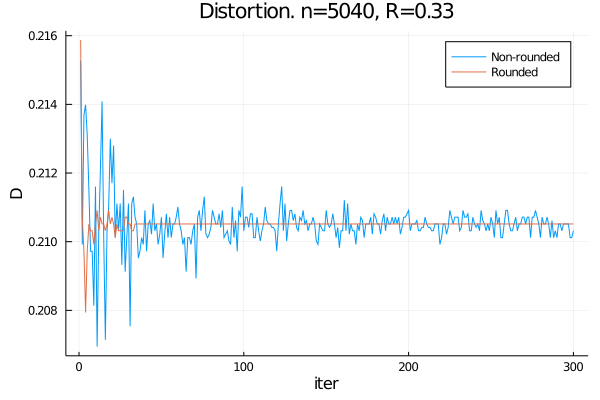

In [80]:
j = 1
plot(1:algo.maxiter, dist_non_rounded[j], label="Non-rounded")
plot!(1:algo.maxiter, dist_rounded[j], label="Rounded")
title!("Distortion. n=$n, R=$(round(R[j],digits=2))"); xlabel!("iter"); ylabel!("D")